# AIDA Data Science Workshop #6

Continuation of last week! This time with slightly more complex datasets and (subjectively) cooler graphs! It's gonna be awhile until our next workshop (the Sunday after Spring Break (3/29)), but that workshop will be on webscraping, data collecting, and some more data cleansing. As always, if you have any suggestions for future content, feel free to let us know!

## Review of Last Time
- `df["column_name"]` will return you the data within one column (as a `Series`) while `df[["column_name"]]` will return you a subset of the dataframe (pay atttention to the type of the variables you use)

- `gpa_cs = gpa[gpa['Subject'] == 'CS']` is a way to filter the dataframe `gpa_cs` for all rows that have the `Subject` column equal to the string `'CS'`
  - Bonus: figure out why the syntax is the way it is

- Make sure column names don't have any special characters in them (quotations, spaces, etc.), and if they do, make sure to take those into account when indexing
  - Can rename columns or drop columns to get around this

- The way to concatenate many different plots into one is to use `fig = go.Figure()` then add each graph as a "trace" using `fig.add_trace(go.Box())` (or any other type of graph) with an optional `go.Layout()` object for additional layout options

- [Link to last week's solutions](https://colab.research.google.com/drive/1NbY5D7CbedAkQNMiE_6rhRLTu83dyAuD)

In [2]:
!pip install chart_studio

import pandas as pd
import numpy as np
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
from urllib.request import urlopen

import plotly.io as pio
pio.renderers.default = 'colab'

     |████████████████████████████████| 71kB 2.0MB/s 


## Example 1: Noise Complaints in Urbana
https://data.ccrpc.org/dataset/nuisance-complaints  
This dataset has data from 2003, and gives the street name, block number, type of complaint, among other data. The goal would be to produce some type of map visualization looking into some statistic of your choosing. An easy one to start with would be to plot the number of complaints by their location (location, luckily, is given by latitude longitude coordinates in "Mapped Location"). Since it might take a little longer than the time allotted to figure out ways to properly parse the mapped location into two separate columns (latitude and longitude separately), we have done that for you already.



In [4]:
noise_complaints = pd.read_csv("https://data.urbanaillinois.us/api/views/tsn9-95m3/rows.csv?accessType=DOWNLOAD")
noise_complaints

,File Number,Date Reported,Year Reported,Month Reported,Housing Block,Street Name,Date Notice Mailed or Given,Type of Complaint,Disposition,File Close Date,Method Submitted,Submitted Online?,Total Fees,Mapped Location
0,411015,11/16/2004,2004,11,1700 BLOCK,S Philo Rd,NaN,Municipal Waste,City Abated,NaN,Not Available,False,0.0,"1700 S Philo Rd\nUrbana, IL"
1,308006,08/05/2003,2003,8,1500 BLOCK,N Carver,NaN,Weeds/Grass,Owner Abated,NaN,Not Available,False,0.0,"1500 N Carver\nUrbana, IL"
2,705011,05/02/2007,2007,5,400 BLOCK,S Johnson St,05/03/2007,Weeds/Grass,Owner Abated,05/11/2007,Not Available,False,0.0,"400 S Johnson St\nUrbana, IL"
3,303002,03/03/2003,2003,3,1100 BLOCK,S Lanore,NaN,Municipal Waste,Owner Abated,NaN,Not Available,False,0.0,"1100 S Lanore\nUrbana, IL"
4,308073,08/26/2003,2003,8,500 BLOCK,S Broadway,NaN,Weeds/Grass,Invalid,NaN,Not Available,False,0.0,"500 S Broadway\nUrbana, IL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10172,19-001206,06/17/2019,2019,6,600 Block,West Oregon Street,06/17/2019,Weeds/Grass,Voluntarily Complied,07/01/2019,Phone,False,0.0,"600 West Oregon Street\nUrbana, IL\n(40.107511..."
10173,308026,08/07/2003,2003,8,200 BLOCK,W High St,NaN,Weeds/Grass,Owner Abated,NaN,Not Available,False,0.0,"200 W High St\nUrbana, IL\n(40.109916, -88.208..."
10174,510030,10/13/2005,2005,10,700 BLOCK,N Busey Av,NaN,Municipal Waste,Owner Abated,NaN,Not Available,False,0.0,"700 N Busey Av\nUrbana, IL\n(40.118696, -88.21..."
10175,406076,06/30/2004,2004,6,400 BLOCK,S Johnson,NaN,Municipal Waste,Owner Abated,NaN,Not Available,False,0.0,"400 S Johnson\nUrbana, IL\n(40.109874, -88.196..."


### Some Initial Data Exploration

In [5]:
noise_complaints.describe(include="all")

,File Number,Date Reported,Year Reported,Month Reported,Housing Block,Street Name,Date Notice Mailed or Given,Type of Complaint,Disposition,File Close Date,Method Submitted,Submitted Online?,Total Fees,Mapped Location
count,10177,10177,10177.000000,10177.00000,10177,10177,7026,10098,10066,7215,10138,10177,10177.000000,10177
unique,10148,2726,NaN,NaN,68,1042,1937,5,7,1960,6,2,NaN,2318
top,1412005,05/15/2018,NaN,NaN,700 BLOCK,E Michigan Av,05/03/2012,Weeds/Grass,Owner Abated,10/31/2018,Not Available,False,NaN,"700 W Illinois St\nUrbana, IL\n(40.109128, -88..."
freq,2,21,NaN,NaN,911,277,25,6132,6846,118,8595,10107,NaN,145
mean,NaN,NaN,2010.788051,6.52658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.878170,NaN
std,NaN,NaN,5.235040,2.58718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.738678,NaN
min,NaN,NaN,2003.000000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,2006.000000,5.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,2010.000000,6.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,2015.000000,8.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


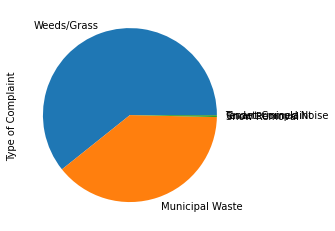

In [6]:
noise_complaints["Type of Complaint"].value_counts().plot.pie()

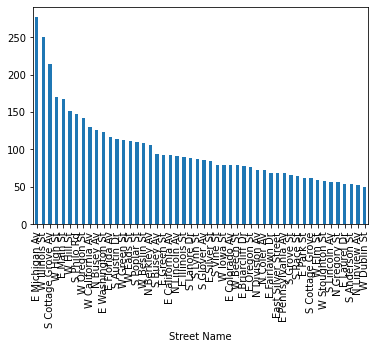

In [7]:
nc_agg = noise_complaints.groupby("Street Name")\
                         .size()\
                         .sort_values(ascending=False)
nc_agg.head(50).plot.bar()

In [8]:
# the data is stored in the format "Street Name\nCity, State\n(lat, lon)"
# split the string by \n and get the first element of the list to get the street name
noise_complaints["Mapped Location"].str.split("\n")\
                                   .str.get(0)\
                                   .value_counts()

700 W Illinois St          145
1100 S Austin Dr           103
1300 E Silver St            71
800 W Oregon St             71
1300 East Silver Street     63
                          ... 
1400 S Greenridge Dr         1
2000 Vawter                  1
700 W High Street            1
1800 E Michigan Ave          1
600 S Anderson               1
Name: Mapped Location, Length: 2315, dtype: int64

### Data Cleaning (don't open if you want to work on this on your own)

In [9]:
# we can get the last element of the split list to get the (lat, lon) pair (index -1)
latlong_prep = noise_complaints["Mapped Location"].str.split("\n")\
                                                  .str.get(-1)\
                                                  .str.replace("[\(\)]", "")

# some mapped locations only had a street and city name, but no lat lon
# we could potentially look up these lat lon positions, but for the purposes
# of this workshop, we will ignore those.
urbana_removed = latlong_prep[latlong_prep != "Urbana, IL"]
urbana_removed

6        40.113383, -88.217679
15       40.103805, -88.188643
17       40.112297, -88.197845
23       40.109403, -88.194514
27       40.107453, -88.217705
                 ...          
10172    40.107511, -88.214566
10173    40.109916, -88.208812
10174    40.118696, -88.216934
10175    40.109874, -88.196843
10176    40.122193, -88.225758
Name: Mapped Location, Length: 9626, dtype: object

In [10]:
# Count the occurrences of each Mapped Location (str of (lat, lon)) using .value_counts()
# then rename the columns so we can access them later
latlong_df = urbana_removed.value_counts()\
                           .rename_axis("Mapped Location")\
                           .reset_index(name="Count")

# Split the string (lat, lon) by ", " -> [lat, lon] in every cell
# Use .apply(pd.Series) to turn the array into two columns
# Rename the columns
latlong = latlong_df["Mapped Location"].str.split(", ")\
                                       .apply(pd.Series)\
                                       .rename(columns={0: "Latitude", 1: "Longitude"})

# Create the latlong dataframe with all of the information needed to plot                                       
latlong["Number of Noise Complaints"] = latlong_df["Count"]
latlong["Text Label"] = latlong_df["Count"].apply("{} noise complaint(s)".format)

### Map Visualization

In [ ]:
# Here is the cleaned lat long data. If you want to try to do this part on your own,
# then either remove the previous cells or hide them and use your own variables.
latlong

,Latitude,Longitude,Number of Noise Complaints,Text Label
0,40.109128,-88.216254,157,157 noise complaint(s)
1,40.091481,-88.193041,145,145 noise complaint(s)
2,40.10381,-88.187513,118,118 noise complaint(s)
3,40.107453,-88.217705,102,102 noise complaint(s)
4,40.108293,-88.216019,97,97 noise complaint(s)
...,...,...,...,...
877,40.092271,-88.192976,1,1 noise complaint(s)
878,40.118087,-88.16864,1,1 noise complaint(s)
879,40.099892,-88.208395,1,1 noise complaint(s)
880,40.098321,-88.208757,1,1 noise complaint(s)


In [ ]:
# Go to mapbox.com, sign up for an account, and look around in your account settings
# for an "API Key". If you need help, ask someone.
# These API keys are meant to be private and per user, so make sure you don't commit
# API keys to GitHub!
MAPBOX_ACCESS_TOKEN = ""

urbana_center = {"lat": 40.1106, "lon": -88.2073}

# We used go.Scattermapbox() because we can get a Google Maps-like map, but
# you can use whatever you want. Start your code here!


## Example 2: Police Incidents In Urbana
https://data.ccrpc.org/dataset/police-incidents-since-1988  
This dataset is a massive table of records for various police incidents in Urbana since 1988. The goal here is to create an interactive visualization using plotly. Some things you could do with this data could be finding which month has in general the most incidents or what crime happens the most by year.

In [ ]:
police_incidents = pd.read_csv("https://data.urbanaillinois.us/api/views/uj4k-8xe8/rows.csv?accessType=DOWNLOAD")
# this line throws you a DtypeWarning
# pandas attempts to guess what kind of value should go in what columns, in this case, Columns (21)
# you can specify a specific dtype for a column by adding "dtype={"column_name":type}"
# See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

police_incidents

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



,INCIDENT,DATE OCCURRED,TIME OCCURRED,YEAR OCCURRED,MONTH OCCURRED,DATE REPORTED,TIME REPORTED,DATE ARRIVED,TIME ARRIVED,GEO CODE,HOUSE NUMBER BLOCK,STREET,CRIME CODE,CRIME DESCRIPTION,CRIME CATEGORY,CRIME CATEGORY DESCRIPTION,CSA DESCRIPTION,PLACE CODE,PLACE CODE DESCRIPTION,WEAPONS CODE 1,WEAPON 1 DESCRIPTION,WEAPONS CODE 2,WEAPON 2 DESCRIPTION,WEAPONS CODE 3,WEAPON 3 DESCRIPTION,BIAS CODE,BIAS DESCRIPTION,STATUS CODE,STATUS DESCRIPTION,COUNTER,MAPPING ADDRESS
0,U89-01009,03/04/1989,00:00,1989,3,03/04/1989,00:00,03/04/1989,14:37,000-00,1,NaN,6519,ABANDONED JUNK VEHICLES,NaN,NaN,COMMITTED,304,STREET,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,9.0,ADMINISTRATIVELY CLOSED,1,NaN
1,U88-00035,01/03/1988,22:01,1988,1,01/03/1988,22:01,01/03/1988,22:03,547-12,NaN,E MAIN ST,9309,MENTAL CASES-OTHER,C40,Crisis Intervention,COMMITTED,90,APARTMENT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,9.0,ADMINISTRATIVELY CLOSED,1,NaN
2,U88-00149,01/08/1987,13:10,1987,1,01/08/1987,13:10,01/08/1987,13:10,576-09,NaN,S VINE ST,9028,ASSIST SICK & INJURED,NaN,NaN,COMMITTED,300,SCHOOL,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10.0,"CLEARED EXCEPTIONALLY, JUVENILE NO CUSTODY",1,NaN
3,U88-00119,01/10/1988,04:57,1988,1,01/10/1988,04:57,01/10/1988,05:04,547-13,NaN,N COTTAGE GROVE AVE,9425,SUICIDE ATTEMPT/SUFFOCATION,C38,"Suicide, Attempts, and Threats",COMMITTED,210,GARAGE - RESIDENTIAL,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,9.0,ADMINISTRATIVELY CLOSED,1,NaN
4,U88-02809,06/11/1988,00:00,1988,6,06/11/1988,02:55,06/11/1988,03:00,547-05,NaN,N BROADWAY AVE,9309,MENTAL CASES-OTHER,NaN,NaN,COMMITTED,90,APARTMENT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,9.0,ADMINISTRATIVELY CLOSED,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462107,U96-01542,03/23/1996,01:59,1996,3,03/23/1996,01:59,03/23/1996,01:59,547-08,600 BLOCK,N CUNNINGHAM AVE,2170,DRUG EQUIPMENT-POSSESSION,C26,Drug Paraphernalia Act,COMMITTED,278,PARKING LOT - BUSINESS,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,CLEARED BY ADULT ARREST,1,"600 N CUNNINGHAM AVE\nURBANA, IL\n(40.118012, ..."
462108,U14-03381,06/15/2014,22:46,2014,6,06/15/2014,22:46,06/15/2014,22:48,519-07,1 BLOCK,N KENYON RD,6621,FAILURE TO REDUCE SPEED,C28,Traffic Offenses,COMMITTED,304,STREET,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NONE,3.0,CLEARED BY ADULT ARREST,1,"1 N KENYON RD\nURBANA, IL"
462109,U01-04446,07/21/2001,06:44,2001,7,07/21/2001,06:44,07/21/2001,00:00,546-11,1 BLOCK,UNIVERSITY AVE,6568,ACCIDENT INVOLVING OTHER CITY PROP,C37,Accident,COMMITTED,304,STREET,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NONE,9.0,ADMINISTRATIVELY CLOSED,1,"1 UNIVERSITY AVE\nURBANA, IL\n(40.116339, -88...."
462110,U12-04959,09/04/2012,08:38,2012,9,09/04/2012,08:38,09/04/2012,08:38,577-05,1500 BLOCK,HUNTER ST,1200,POSSESSION STOLEN PROPERTY,C11,Theft,COMMITTED,96,PARKING LOT-APARTMENT,99,NONE,NaN,NaN,NaN,NaN,88.0,NONE,3.0,CLEARED BY ADULT ARREST,1,"1500 HUNTER ST\nURBANA, IL\n(40.103603, -88.19..."


In [ ]:
# Start your code here!


## Example 3: COVID-19
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

This dataset is a table of COVID-19 cases by day for either all states in the US or globally. We will be using the US data for this workshop, but feel free to expand.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
# We need FIPS codes to be a string, not a float (error on their encoding)
# See https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt
df["FIPS"] = df["FIPS"].apply(lambda x: f"{x:05.0f}")
# Example calculating total
df["Total"] = df.loc[:,"1/22/20":"10/2/20"].sum(axis=1)
df

In [ ]:
# Start your code for a choropleth here!


In [ ]:
# Start your code for a timeline here!


## Sneak Peek into 10/10 Meeting: API REST Endpoints
We'll be looking into some data collection sources, and one is an API (Application Programming Interface). Here we'll look into getting data from the [CUMTD bus API](https://developer.cumtd.com/).

In [ ]:
import requests
import json

# Insert your API key here! (Get it from https://developer.cumtd.com)
# It may take a little while for the key to become activated.
CUMTD_API_KEY = ""

In [ ]:
args = {
    "version": "v2.2",
    "format": "json",
    "key": CUMTD_API_KEY,
    "origin_stop_id": "PKLN:1",
    "destination_stop_id": "UNIPSPCT:6"
}
url = "https://developer.cumtd.com/api/{version}/{format}/getplannedtripsbystops&key={key}&origin_stop_id={origin_stop_id}&destination_stop_id={destination_stop_id}".format(**args)

r = requests.get(url)
text = r.text
json_result = json.loads(text)
json_result

{'new_changeset': True,
 'rqst': {'params': {}},
 'status': {'code': 401, 'msg': 'invalid key'},
 'time': '2020-03-08T15:15:52-05:00'}

In [ ]:
# Start your code here!
if json_result["status"]["code"] == 200:
    pass
else:
    print("Oh no! Error in request: " + json_result["status"]["msg"])

Oh no! Error in request: invalid key
